In [1]:
# testing consequences of interventions on gpt2, and how they match up against our SAE's
import datasets
import torch
from einops import einsum
from safetensors.torch import load_file
from tqdm import tqdm
from transformers import AutoTokenizer

from sae.data import chunk_and_tokenize


In [2]:
from functools import partial

from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model = GPT2LMHeadModel.from_pretrained("gpt2").cuda()
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

sae_ckpt = load_file(
    "/home/sid/tensor-sae/checkpoints/layer-4-test/sae.safetensors", device="cuda"
)

feature_encoder_weights = sae_ckpt["encoder.weight"]
feature_encoder_bias = sae_ckpt["encoder.bias"]
# legacy keys
feature_decoder_weights = sae_ckpt["W_dec"]
feature_decoder_bias = sae_ckpt["b_dec"]

intervention_index = 5
readout_index = 8


def create_hooks(
    model,
    intervention_index,
    readout_index,
    lambda_value,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
):
    first_activation_positions = None
    consequent_embeddings = None
    causal_embeddings = None
    v_j = None

    def strengthen_sae_feature(module, input, output, layer_offset=0):
        nonlocal first_activation_positions, causal_embeddings, v_j

        embed_dim = output[0].shape[-1]
        feature_encoder_segment = feature_encoder_weights[
            :,
            (intervention_index - layer_offset) * embed_dim : (
                intervention_index - layer_offset + 1
            )
            * embed_dim,
        ]
        feature_decoder_segment = feature_decoder_weights[
            :,
            (readout_index - layer_offset) * embed_dim : (
                readout_index - layer_offset + 1
            )
            * embed_dim,
        ]

        feature_activation = (
            einsum(output[0], feature_encoder_segment.T, "b s e, e n -> b s n")
            - feature_encoder_bias
        )
        feature_activation, max_feature_index = torch.max(feature_activation, dim=-1)

        first_activation_positions = (feature_activation > 0).float().argmax(dim=1)
        has_activation = (feature_activation > 0).any(dim=1)
        first_activation_positions[~has_activation] = -1

        batch_size, seq_len, embed_dim = output[0].shape

        mask = torch.arange(seq_len, device=output[0].device).unsqueeze(0).expand(
            batch_size, -1
        ) == first_activation_positions.unsqueeze(1)

        causal_embeddings = output[0]
        mask = mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        v_j = (
            feature_decoder_segment.unsqueeze(0)
            .expand(output[0].shape[0], -1, -1)
            .gather(1, max_feature_index.unsqueeze(-1).expand(-1, -1, embed_dim))
        )
        new_output = output[0] + lambda_value * mask * v_j

        new_outputs = [new_output] + list(output[1:])
        return tuple(new_outputs)

    def return_consequent_layer(module, input, output):
        nonlocal consequent_embeddings, first_activation_positions

        batch_size, seq_len, embed_dim = output[0].shape

        mask = torch.arange(seq_len, device=output[0].device).unsqueeze(0).expand(
            batch_size, -1
        ) == first_activation_positions.unsqueeze(1)
        mask = mask.unsqueeze(-1).expand(-1, -1, embed_dim)

        filtered_output = output[0]
        consequent_embeddings = filtered_output.sum(dim=1)

        # Return the original output unchanged
        return output

    intervention_hook = model.transformer.h[intervention_index].register_forward_hook(
        partial(strengthen_sae_feature, layer_offset=intervention_index)
    )
    readout_hook = model.transformer.h[readout_index].register_forward_hook(
        return_consequent_layer
    )

    return (
        intervention_hook,
        readout_hook,
        lambda: consequent_embeddings,
        lambda: causal_embeddings,
        lambda: v_j,
    )


def process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    lam,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
):
    (
        intervention_hook,
        readout_hook,
        get_consequent_embeddings,
        get_causal_embeddings,
        get_v_j,
    ) = create_hooks(
        model,
        intervention_index,
        readout_index,
        lam,
        feature_encoder_weights,
        feature_encoder_bias,
        feature_decoder_weights,
    )

    with torch.no_grad():
        model(**inputs)

    consequent_embeddings = get_consequent_embeddings()
    causal_embeddings = get_causal_embeddings()
    v_j = get_v_j()

    intervention_hook.remove()
    readout_hook.remove()

    return (consequent_embeddings, causal_embeddings, v_j)


# Example usage
intervention_index = 5
readout_index = 8
text = ["Hello, world!", "Hello, world!"]
inputs = tokenizer(text, return_tensors="pt").to("cuda")

# Assuming you have these variables defined
# feature_encoder_weights, feature_encoder_bias, feature_decoder_weights

consequent_embeddings, causal_embeddings, _ = process_text(
    model,
    inputs,
    intervention_index,
    readout_index,
    1.0,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
)

print(f"shape of output embeddings: {consequent_embeddings.shape}")
print(f"shape of causal embeddings: {causal_embeddings.shape}")

shape of output embeddings: torch.Size([2, 768])
shape of causal embeddings: torch.Size([2, 4, 768])


In [3]:
#next code we would need to add:
#filter out any batch elements where the SAE doesn't trigger
#compare to activations from a hook on the clean sequence
#subtract, compute comparisons, etc.!

In [4]:
#I suspect the most efficient way to go about thos jacobian computation is to modify the gpt2 forward pass

In [5]:
model.transformer.h

ModuleList(
  (0-11): 12 x GPT2Block(
    (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn): GPT2SdpaAttention(
      (c_attn): Conv1D()
      (c_proj): Conv1D()
      (attn_dropout): Dropout(p=0.1, inplace=False)
      (resid_dropout): Dropout(p=0.1, inplace=False)
    )
    (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): GPT2MLP(
      (c_fc): Conv1D()
      (c_proj): Conv1D()
      (act): NewGELUActivation()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

In [6]:
def compute_jacobian(model, j_activations, i, j, k):
    """
    Compute the Jacobian of layer k's activations with respect to layer j's activations at position i.

    Args:
    - model: GPT2Model instance
    - j_activations: activations of layer j (shape: [batch_size, seq_len, hidden_size])
    - i: token position
    - j: index of the input layer
    - k: index of the output layer

    Returns:
    - Jacobian matrix
    """
    # Ensure j_activations requires grad
    j_activations.requires_grad_(True)

    # Forward pass to get k_activations
    def forward_to_k(x):
        # Forward pass from j to k
        activations = x
        for layer_idx in range(j, k + 1):
            activations = model.transformer.h[layer_idx](activations)[0]
        return activations[:, i, :]

    # Compute Jacobian
    jacobian = torch.autograd.functional.jacobian(forward_to_k, j_activations)

    return jacobian.squeeze(0, 2)[:, i, :]  # selecting only token pos i.
    # But if we're pre-computing, we could just return the jacobian.squeeze(0,2)

In [7]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
).select(range(16))
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=64)

num_proc must be <= 16. Reducing num_proc to 16 for dataset of size 16.


In [8]:
tokenized

Dataset({
    features: ['input_ids', 'overflow_to_sample_mapping'],
    num_rows: 4299
})

In [9]:
# Collect activations from GPT2
sample = tokenized[0]["input_ids"]
j, k = 5, 8
lam = 1e-9
(consequent_embeddings, causal_embeddings, v_j) = process_text(
    model,
    {
        "input_ids": sample.cuda(),
        "attention_mask": torch.ones_like(sample, device="cuda:1"),
    },
    j,
    k,
    lam,
    feature_encoder_weights,
    feature_encoder_bias,
    feature_decoder_weights,
)

In [10]:
# Generate random input
# batch_size, seq_len = 1, 10
# j_activations = torch.randn(batch_size, seq_len, 768, device="cuda:1")

# Compute Jacobian for predicting layer 5 activations from layer 3 activations at position 2
i, j, k = 2, 3, 5
jacobian = compute_jacobian(model, causal_embeddings, i, j, k)

print(f"Jacobian shape: {jacobian.shape}")

Jacobian shape: torch.Size([768, 768])


In [11]:
# Compare jacobian and local approximation
with torch.no_grad():
    jacobian_approx = causal_embeddings[:, i, :] + jacobian * v_j[:, i, :] * lam
    local_approx = causal_embeddings[:, i, :] + v_j[:, i, :] * lam

In [12]:
torch.norm(jacobian_approx - local_approx)

tensor(0., device='cuda:0')

In [13]:
def get_active_latents_first_pos(
    output, feature_encoder_weights, feature_encoder_bias, i, j
):
    # concat hidden states for layer range
    all_hidden_states = torch.cat(
        [output.hidden_states[idx] for idx in range(i, j + 1)], dim=-1
    )
    feature_activation = (
        einsum(all_hidden_states, feature_encoder_weights.T, "b s e, e n -> b s n")
        - feature_encoder_bias
    )
    max_feature_activation, _ = torch.max(feature_activation, dim=-1)
    first_activation_positions = (
        (max_feature_activation > 0).float().argmax(dim=1, keepdim=True)
    )
    expanded_pos = first_activation_positions.unsqueeze(-1).expand(
        -1, -1, all_hidden_states.shape[-1]
    )
    token_activations = all_hidden_states.gather(1, expanded_pos)
    num_fired = (token_activations > 0).sum(dim=-1)

    return num_fired

In [14]:
dataset = datasets.load_dataset(
    "togethercomputer/RedPajama-Data-1T-Sample",
    split="train",
    trust_remote_code=True,
)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenized = chunk_and_tokenize(dataset, tokenizer, max_seq_len=128)

In [17]:
import gc

num_samples = 8192
bsz = 256
# for each sample compute activation positions and fired pre-act latents
sample = tokenized.select(range(num_samples))

dist = []

for batch in tqdm(sample.iter(bsz), total=num_samples // bsz):
    with torch.no_grad():
        out = model(
            input_ids=batch["input_ids"].cuda().unsqueeze(0), output_hidden_states=True
        )
    num_active = get_active_latents_first_pos(
        out, feature_encoder_weights, feature_encoder_bias, 6, 11
    )
    dist.extend(num_active.squeeze().cpu().tolist())

torch.cuda.empty_cache()
gc.collect()

100%|██████████| 64/64 [01:39<00:00,  1.56s/it]


132

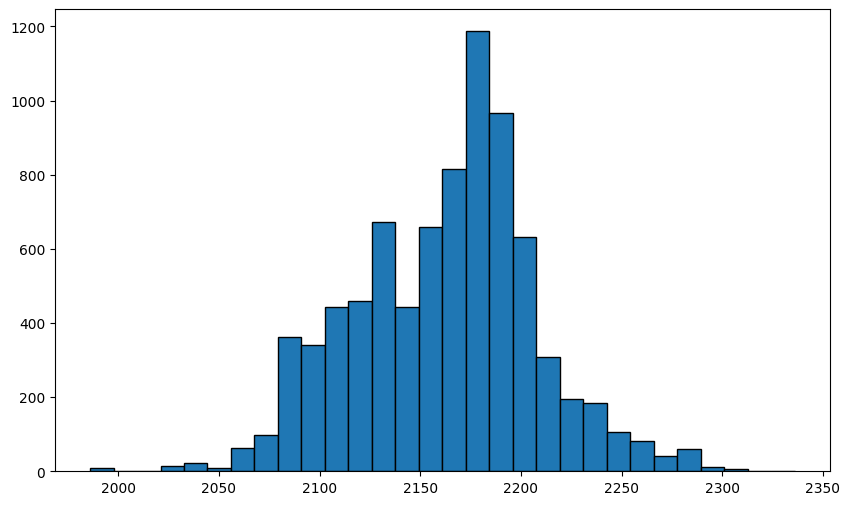

In [18]:
import matplotlib.pyplot as plt

# Create the histogram
plt.figure(figsize=(10, 6))
_ = plt.hist(dist, bins=30, edgecolor='black')